<a href="https://colab.research.google.com/github/alirezash97/Cardio/blob/master/HeartBeat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install kaggle
!mkdir .kaggle
import json
token = {"username":"alirezashafaei97","key":"9cb262aa0c5658ffc4eb45857c41903c"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d shayanfazeli/heartbeat -p /content
!unzip /content/heartbeat.zip -d /content/heartbeat

In [2]:
import pandas as pd
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.layers import (Input, Dense, LeakyReLU, Softmax, InputLayer, concatenate, Conv1D, MaxPool1D, Add, MaxPooling1D
 , Flatten, Dropout, ReLU, BatchNormalization, GlobalAveragePooling1D)
from keras.utils.np_utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from random import uniform 
import random


from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix


Using TensorFlow backend.


In [0]:
train_df=pd.read_csv('/content/heartbeat/mitbih_train.csv',header=None)
test_df=pd.read_csv('/content/heartbeat/mitbih_test.csv',header=None)

In [0]:
# del train_df
# del test_df

In [4]:
train_df[187]=train_df[187].astype(int)
counter=train_df[187].value_counts()
print(counter)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


In [0]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=10000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=10000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=10000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=10000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=10000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [0]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [7]:
equilibre=train_df[187].value_counts()
print(equilibre)

4    10000
3    10000
2    10000
1    10000
0    10000
Name: 187, dtype: int64


In [8]:
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
c

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
5510,0.894231,0.788462,0.525641,0.330128,0.368590,0.368590,0.336538,0.413462,0.291667,0.195513,0.208333,0.227564,0.227564,0.237179,0.272436,0.298077,0.323718,0.333333,0.381410,0.391026,0.480769,0.522436,0.544872,0.519231,0.544872,0.535256,0.522436,0.512821,0.512821,0.471154,0.512821,0.490385,0.378205,0.464744,0.439103,0.323718,0.375000,0.477564,0.282051,0.307692,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
73836,0.990017,0.737105,0.098170,0.108153,0.299501,0.312812,0.326123,0.327787,0.322795,0.319468,0.311148,0.314476,0.321131,0.321131,0.312812,0.324459,0.327787,0.322795,0.329451,0.337770,0.351082,0.349418,0.342762,0.357737,0.382695,0.407654,0.417637,0.424293,0.440932,0.435940,0.407654,0.396007,0.399334,0.399334,0.399334,0.399334,0.391015,0.371048,0.351082,0.341098,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
77360,0.982097,1.000000,0.716113,0.396419,0.281330,0.296675,0.212276,0.107417,0.000000,0.025575,0.056266,0.132992,0.166240,0.222506,0.230179,0.271100,0.245524,0.265985,0.301790,0.329923,0.322251,0.355499,0.329923,0.327366,0.332481,0.322251,0.301790,0.324808,0.306905,0.306905,0.324808,0.324808,0.260870,0.276215,0.245524,0.255754,0.237852,0.263427,0.222506,0.237852,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
80980,1.000000,0.856742,0.632023,0.331461,0.091292,0.091292,0.098315,0.066011,0.057584,0.040730,0.030899,0.030899,0.014045,0.005618,0.005618,0.001404,0.000000,0.001404,0.004213,0.022472,0.030899,0.036517,0.067416,0.089888,0.120787,0.155899,0.189607,0.224719,0.251404,0.271067,0.303371,0.320225,0.327247,0.328652,0.320225,0.317416,0.297753,0.273876,0.269663,0.241573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
83491,0.880546,0.532423,0.518771,0.491468,0.457338,0.406143,0.365188,0.303754,0.232082,0.095563,0.037543,0.010239,0.030717,0.030717,0.088737,0.160410,0.245734,0.317406,0.365188,0.385666,0.430034,0.443686,0.443686,0.467577,0.494881,0.501706,0.511945,0.501706,0.501706,0.501706,0.505119,0.505119,0.515358,0.511945,0.518771,0.522184,0.535836,0.539249,0.549488,0.542662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [0]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.05,186)
    return (signal+noise)

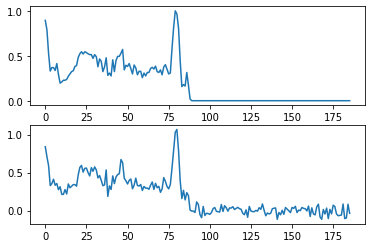

In [10]:
tempo=c.iloc[0,:186]
bruiter=add_gaussian_noise(tempo)

plt.subplot(2,1,1)
plt.plot(c.iloc[0,:186])

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()

In [0]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [0]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
# X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
# X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [13]:
print(X_train.shape)
print(X_test.shape)

(50000, 186)
(21892, 186)


In [0]:
# data augmentation

def augmetation(X_train, y_train, chance):

  augment_number = 0
  XF_train = np.zeros((X_train.shape[0]*2, X_train.shape[1]))
  yf_train = np.zeros((y_train.shape[0]*2, y_train.shape[1]))
  pointer = 0
  for index, row in enumerate(X_train):

    XF_train[pointer, :] = row
    yf_train[pointer, :] = y_train[index, :]
    pointer += 1

    rand_num = random.uniform(0, 1)      
    if chance > rand_num :

      augment_number += 1
      noise = np.random.normal(0,0.05,186)
      new_signal = row + noise  
      XF_train[pointer, :] = new_signal
      yf_train[pointer, :] = y_train[index, :]
      pointer += 1

      filled = X_train.shape[0] + augment_number
      XFF_train = XF_train[:filled, :]
      yff_train = yf_train[:filled, :]

    
  return XFF_train, yff_train


In [0]:
X_train, y_train = augmetation(X_train, y_train, 0.1)

In [0]:
# periodic signal extend 

import pywt

XF_train = np.zeros((X_train.shape[0], 9000))
XF_test = np.zeros((X_test.shape[0], 9000))


for index, row in enumerate(X_train):
  XF_train[index, :] = pywt.pad(row, 4407, 'periodic')


for index, row in enumerate(X_test):
  XF_test[index, :] = pywt.pad(row, 4407, 'periodic')

In [0]:
# trainset = train_df.values
# testset = test_df.values

In [0]:
# def split(dataset, number_of_sample_per_category):
  
#   new_dataset = np.zeros((np.sum(number_of_sample_per_category), dataset.shape[1]))
#   pointer = 0
  
#   for row in dataset :
    
#     row_label = int(row[-1])
    
#     if number_of_sample_per_category[row_label] > 0 :
      
#       number_of_sample_per_category[row_label] -= 1
#       new_dataset[pointer , :] = row
#       pointer += 1

#     else:

#       pass
    
  
#   return new_dataset




In [0]:
# temp_trainset = split(trainset, [5500, 2223, 5500, 641, 5500])
# temp_testset = split(testset, [500, 500, 500, 500, 500])

In [0]:
# augmented = 0
# def data_augmentation(dataset, chance):
  
#   augmented = 0
#   number_of_rows = int(dataset.shape[0] + (dataset.shape[0] * (chance*2)))
#   new_dataset = np.zeros((number_of_rows, dataset.shape[1]))
#   pointer = 0 

#   for row in dataset:
    
#     rand_num = random.uniform(0, 1)
#     if rand_num < chance:
      
#       augmented += 1
#       noise = np.random.normal(scale=0.01, size=187)
#       new_signal = np.zeros((1, 188))
#       new_signal[:, :187] = row[:187] + noise
#       new_signal[:, -1:] = row[-1:] 
#       new_dataset[pointer:pointer+1, :] = new_signal
#       pointer += 1

#     else :
#       pass

#     new_dataset[pointer, :] = row 
#     pointer += 1

#   return augmented, new_dataset  

  

In [0]:
# augmented, trainset = data_augmentation(temp_trainset, 0.08)

In [0]:
# filled = augmented + temp_trainset.shape[0]
# trainset = trainset[:filled , :]

In [0]:
# trainset = np.take(trainset,np.random.permutation(trainset.shape[0]),axis=0,out=trainset)
# testset = np.take(temp_testset,np.random.permutation(temp_testset.shape[0]),axis=0,out=temp_testset)

In [0]:
# X_temp_train = trainset[:, :-1]
# Y_train = trainset[:, -1:]
# X_temp_test = testset[:, :-1]
# Y_test = testset[:, -1:]

In [0]:
# print("X_train : ", XF_train.shape)
# print("Y_train : ", y_train.shape)
# print("X_test : ", XF_test.shape)
# print("Y_test : ", y_test.shape)

In [0]:

# One Hot enoding for target labels 
# ohe = OneHotEncoder()
# Y_train = ohe.fit_transform(Y_train.reshape(-1,1))
# Y_test = ohe.transform(Y_test.reshape(-1,1))

# # handle sparse matrix for keras 
# Y_train = csr_matrix.toarray(Y_train)
# Y_test = csr_matrix.toarray(Y_test)

In [0]:
# print("X_train : ", X_temp_train.shape)
# print("Y_train : ", Y_train.shape)
# print("X_test : ", X_temp_test.shape)
# print("Y_test : ", Y_test.shape)

In [0]:
# periodic signal extend 

# import pywt

# XF_train = np.zeros((X_temp_train.shape[0], 9000))
# XF_test = np.zeros((X_temp_test.shape[0], 9000))


# for index, row in enumerate(X_temp_train):
#   XF_train[index, :-1] = pywt.pad(row, 4406, 'symmetric')
#   XF_train[index, -1:] = 0


# for index, row in enumerate(X_temp_test):
#   XF_test[index, :-1] = pywt.pad(row, 4406, 'symmetric')
#   XF_test[index, -1:] = 0
 



In [0]:
# for index, row in enumerate(X_temp_train):
#   X_temp_train[index] = add_gaussian_noise(row)
# for index, row in enumerate(X_temp_test):
#   X_temp_test[index] = add_gaussian_noise(row)


In [0]:
XF_train = XF_train.reshape((XF_train.shape[0], 9000, 1))
XF_test = XF_test.reshape((21892, 9000, 1))

In [19]:
print("X_train : ", XF_train.shape)
print("Y_train : ", y_train.shape)
print("X_test : ", XF_test.shape)
print("Y_test : ", y_test.shape)

X_train :  (55012, 9000, 1)
Y_train :  (55012, 5)
X_test :  (21892, 9000, 1)
Y_test :  (21892, 5)


In [20]:
X_input = Input(shape=(9000, 1))
Conv = Conv1D(filters=64, kernel_size=5, strides=3)(X_input)


### step 1 

Conv1_1 = Conv1D(filters=64, kernel_size=9, strides=1, padding='same')(Conv)
Bn1_1 = BatchNormalization()(Conv1_1)
Act1_1 = LeakyReLU()(Bn1_1)
Conv1_2 = Conv1D(filters=64, kernel_size=7, strides=1, padding='same')(Act1_1)
Bn1_2 = BatchNormalization()(Conv1_2)
Act1_2 = LeakyReLU()(Bn1_2)
DO1_1 = Dropout(0.2)(Act1_2)
Conv1_3 = Conv1D(filters=64, kernel_size=9, strides=1, padding='same')(DO1_1)
Bn1_3 = BatchNormalization()(Conv1_3)
shortcut1_1 = Add()([Bn1_3, Conv])
Bn1_4 = BatchNormalization()(shortcut1_1)
Act1_3 = LeakyReLU()(Bn1_4)
##### auxiliary
Conv1_4 = Conv1D(filters=128, kernel_size=7, strides=3, padding='same')(Act1_3)
Bn1_5 = BatchNormalization()(Conv1_4)
Act1_4 = LeakyReLU()(Bn1_5)
###############
Max1_1 = MaxPooling1D(pool_size=5, strides=2)(Act1_4)


## step 2

Conv2_1 = Conv1D(filters=256, kernel_size=3, strides=1, padding='same')(Max1_1)
Bn2_1 = BatchNormalization()(Conv2_1)
Act2_1 = LeakyReLU()(Bn2_1)
Conv2_2 = Conv1D(filters=256, kernel_size=5, strides=1, padding='same')(Act2_1)
Bn2_2 = BatchNormalization()(Conv2_2)
Act2_2 = LeakyReLU()(Bn2_2)
DO2_1 = Dropout(0.2)(Act2_2)
Conv2_3 = Conv1D(filters=128, kernel_size=3, strides=1, padding='same')(DO2_1)
Bn2_3 = BatchNormalization()(Conv2_3)
shortcut2_1 = Add()([Bn2_3, Max1_1])
Bn2_4 = BatchNormalization()(shortcut2_1)
Act2_3 = LeakyReLU()(Bn2_4)
##### auxiliary
Conv2_4 = Conv1D(filters=512, kernel_size=7, strides=2, padding='same')(Act2_3)
Bn2_5 = BatchNormalization()(Conv2_4)
Act2_4 = LeakyReLU()(Bn2_5)
###############
Max2_1 = MaxPooling1D(pool_size=5, strides=3)(Act2_4)



Flat1 = Flatten()(Max2_1)

D1 = Dense(256)(Flat1)
A6 = LeakyReLU()(D1)
D_O = Dropout(0.15)(A6)
D2 = Dense(128)(D_O)
D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs=X_input, outputs=A7)

model.summary()




Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2999, 64)     384         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 2999, 64)     36928       conv1d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2999, 64)     256         conv1d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1719,
    decay_rate=0.7)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [0]:
# overfitting so augment more data and decrease initial learning rate to 1e-3

# compile model
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Early Stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Fit the model
history = model.fit(XF_train, y_train, epochs=7, batch_size=64, validation_data=(XF_test, y_test), callbacks=[es_callback])

Epoch 1/7
860/860 [==============================] - 7778s 9s/step - loss: 3.8281 - accuracy: 0.6426 - val_loss: 0.3030 - val_accuracy: 0.9246
Epoch 2/7
860/860 [==============================] - 8050s 9s/step - loss: 0.3551 - accuracy: 0.8814 - val_loss: 0.3695 - val_accuracy: 0.8722
Epoch 3/7
860/860 [==============================] - 8033s 9s/step - loss: 0.2365 - accuracy: 0.9176 - val_loss: 0.2716 - val_accuracy: 0.9079
Epoch 4/7
860/860 [==============================] - 8097s 9s/step - loss: 0.2672 - accuracy: 0.9205 - val_loss: 0.2414 - val_accuracy: 0.9203
Epoch 5/7


In [1]:
# evaluate the model
scores = model.evaluate(XF_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# save model and architecture to single file
model.save("/content/drive/My Drive/Cardio/HeartBeat.h5")

NameError: ignored

In [0]:
/*

In [0]:
from google.colab import drive
drive.mount('/content/drive')